In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import EState
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr


In [3]:
df = pd.read_csv("dados_pub.csv", header=0)

df.head(10)


,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848
1,OC12C3CC1=CCC23,16,262.009035,1.2579
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264
4,CC1C2OC3CC1CC23,21,143.056110,1.7271
5,O=C1CCC11CCCO1,19,224.339592,3.2981
6,CC1OC(=O)C2C(O)C12,17,176.602214,4.0902
7,N#CCC1=CC=CC=C1,16,188.590112,3.8719
8,N=C1NN=CN=CC1=O,13,322.686765,2.9026
9,COC1C(OC)C1C#N,18,162.900862,4.1458


In [4]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   smiles               133885 non-null  object 
 1   n_atoms              133885 non-null  int64  
 2   homo_lumo_nm         133885 non-null  float64
 3   dipole_moment_debye  133885 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.1+ MB


None

,n_atoms,homo_lumo_nm,dipole_moment_debye
count,133885.000000,133885.000000,133885.000000
mean,17.983740,188.669082,2.706037
std,2.954258,40.050275,1.530394
min,3.000000,73.241233,0.000000
25%,16.000000,158.096361,1.588700
50%,18.000000,182.691945,2.500000
75%,20.000000,210.648965,3.636100
max,29.000000,1852.169560,29.556400


Ao observarmos o máximo do comprimento de onda das moléculas, existe uma certa estranheza devido o número exceder tanto a média.

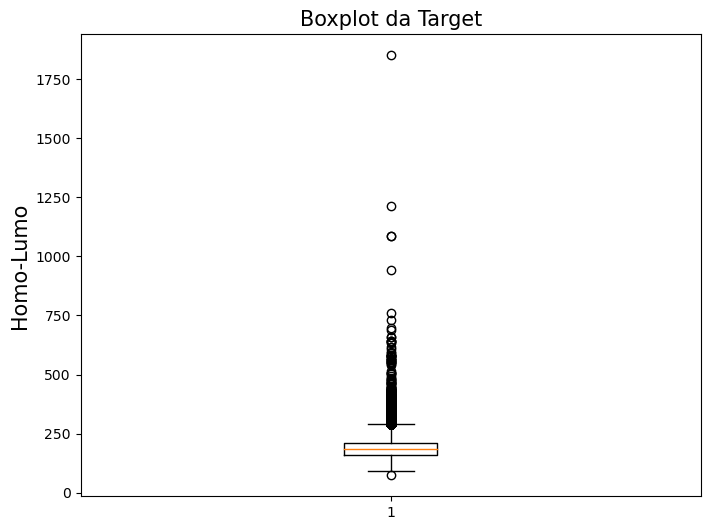

In [6]:

plt.figure(figsize=(8,6))
plt.boxplot(df["homo_lumo_nm"])
plt.title("Boxplot da Target", fontsize=15)
plt.ylabel("Homo-Lumo", fontsize=15)
plt.xlabel("")
plt.show()

Não conseguimos identificar o outlier com boxplot, pois a mediana está muito deslocada.

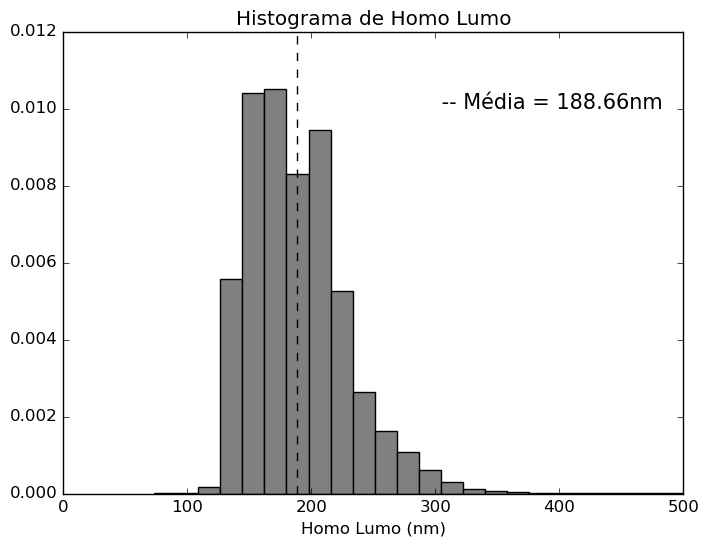

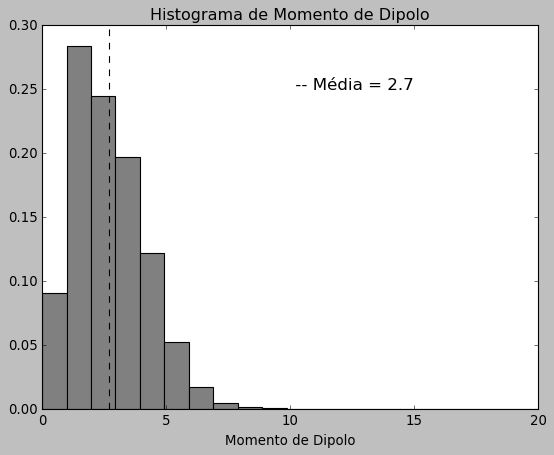

In [5]:
mediahl = int(np.mean(df["homo_lumo_nm"])*100)/100
mediamd = int(np.mean(df["dipole_moment_debye"])*100)/100

plt.figure(figsize=(8,6))
plt.style.use("classic")
plt.hist(df["homo_lumo_nm"], bins=100, density=True, stacked=True, color="gray")
plt.axvline(mediahl, linestyle="--", c="black")
plt.text(300,0.010, s=f" -- Média = {mediahl}nm", fontsize=15)
plt.title("Histograma de Homo Lumo")
plt.xlabel("Homo Lumo (nm)")
plt.xlim(0,500)
plt.show()

plt.hist(df["dipole_moment_debye"], bins=30, density=True, stacked=True, color="gray")
plt.axvline(mediamd, linestyle="--", c="black")
plt.text(10,0.25, s=f" -- Média = {mediamd}", fontsize=15)
plt.title("Histograma de Momento de Dipolo")
plt.xlabel("Momento de Dipolo")
plt.xlim(0,20)
plt.show()



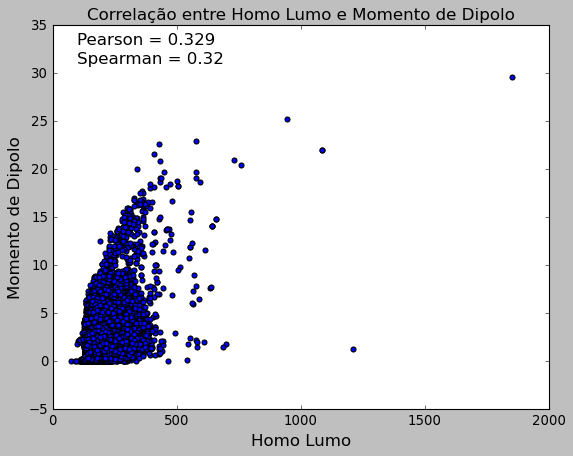

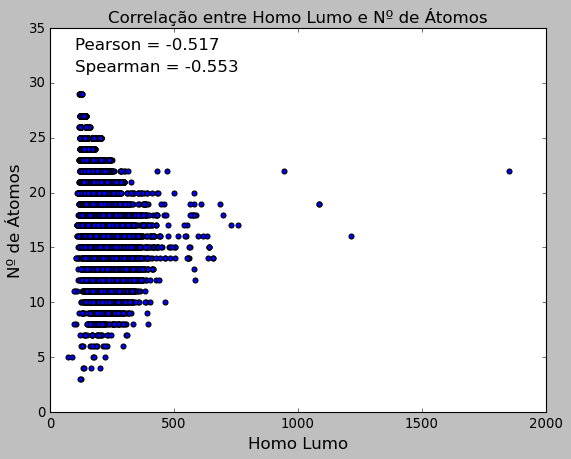

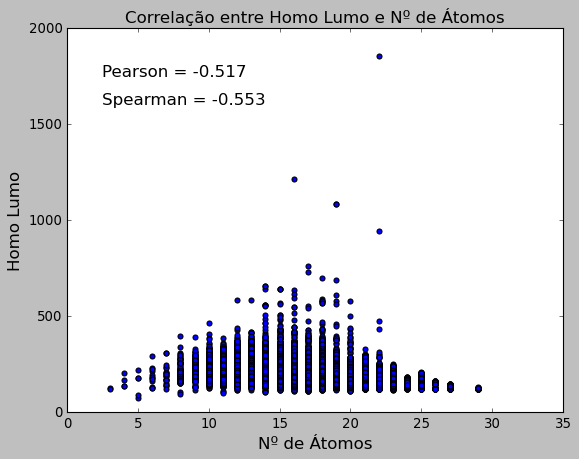

In [6]:
X = df["homo_lumo_nm"]
Y = df["dipole_moment_debye"]
W = df["n_atoms"]

corr, p_value = pearsonr(X,Y)
corrs, p_values = spearmanr(X,Y)
corr = int(corr*1000)/1000
corrs = int(corrs*1000)/1000

plt.figure(figsize=(8,6))
plt.style.use("classic")
plt.scatter(X, Y)
plt.text(100, 33, s=f"Pearson = {corr}", fontsize = 15)
plt.text(100, 31, s=f"Spearman = {corrs}", fontsize=15)
plt.xlim(0,2000)
plt.title("Correlação entre Homo Lumo e Momento de Dipolo", fontsize=15)
plt.xlabel("Homo Lumo", fontsize=15)
plt.ylabel("Momento de Dipolo", fontsize=15)
plt.show()

corr2, p_value2 = pearsonr(X,W)
corrs2, p_values2 = spearmanr(X,W)
corr2 = int(corr2*1000)/1000
corrs2 = int(corrs2*1000)/1000

plt.figure(figsize=(8,6))
plt.style.use("classic")
plt.scatter(X, W)
plt.text(100, 33, s=f"Pearson = {corr2}", fontsize = 15)
plt.text(100, 31, s=f"Spearman = {corrs2}", fontsize=15)
plt.xlim(0,2000)
plt.title("Correlação entre Homo Lumo e Nº de Átomos", fontsize=15)
plt.xlabel("Homo Lumo", fontsize=15)
plt.ylabel("Nº de Átomos", fontsize=15)
plt.show()

plt.figure(figsize=(8,6))
plt.style.use("classic")
plt.scatter(W, X)
plt.text(2.5, 1750, s=f"Pearson = {corr2}", fontsize = 15)
plt.text(2.5, 1600, s=f"Spearman = {corrs2}", fontsize=15)
plt.ylim(0,2000)
plt.title("Correlação entre Homo Lumo e Nº de Átomos", fontsize=15)
plt.ylabel("Homo Lumo", fontsize=15)
plt.xlabel("Nº de Átomos", fontsize=15)
plt.show()


Realizado as análises possíveis com os dados em mãos, podemos tentar implementar análises adicionando mais dados a tabela. Começando pela contagem de ligações triplas com Nitrogênios, o módulo $EState.AtomTypes.TypeAtoms()$, retorna uma lista de caracteres que indicam o tipo de ligação e os atómos da molécula, no caso, contabilizamos "tN", caracter que indica ligações triplas de Nitrogênio.

In [4]:

Z = []

for i in df['smiles']:
    m = Chem.MolFromSmiles(i)
    count = 0
    for j in EState.AtomTypes.TypeAtoms(m):
        if j == ('tN',):
            count += 1
    Z.append(count) 
  


In [5]:
df["QNTD tN"] = Z

df.head(10)

,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye,QNTD tN
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848,1
1,OC12C3CC1=CCC23,16,262.009035,1.2579,0
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626,0
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264,0
4,CC1C2OC3CC1CC23,21,143.056110,1.7271,0
5,O=C1CCC11CCCO1,19,224.339592,3.2981,0
6,CC1OC(=O)C2C(O)C12,17,176.602214,4.0902,0
7,N#CCC1=CC=CC=C1,16,188.590112,3.8719,1
8,N=C1NN=CN=CC1=O,13,322.686765,2.9026,0
9,COC1C(OC)C1C#N,18,162.900862,4.1458,1


Agora, seguindo o livro texto, sabemos que o número de ligações pi influencia o comprimento de onda Homo Lumo da molécula, desse modo, podemos utilizar da informação de que ligações duplas contém (1 sigma e 1 pi), e ligações triplas contém (1 sigma e 2 pi). As ligações entre os átomos são listadas utilizando a função $Get.Bond.Type()$, podendo referenciar as ligações por dupla $.DOUBLE$ e triplas $.TRIPLE$.

In [6]:
ligações_pi = []

for j in df["smiles"]:
    m = Chem.MolFromSmiles(j)
    pi = 0
    for i in m.GetBonds():
        if i.GetBondType() == Chem.BondType.DOUBLE:
            pi += 1
        elif i.GetBondType() == Chem.BondType.TRIPLE:
            pi += 2

    ligações_pi.append(pi)

df["lig. pi"] = ligações_pi


In [10]:
df.head(10)

,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye,QNTD tN,lig. pi
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848,1,4
1,OC12C3CC1=CCC23,16,262.009035,1.2579,0,1
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626,0,0
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264,0,0
4,CC1C2OC3CC1CC23,21,143.056110,1.7271,0,0
5,O=C1CCC11CCCO1,19,224.339592,3.2981,0,1
6,CC1OC(=O)C2C(O)C12,17,176.602214,4.0902,0,1
7,N#CCC1=CC=CC=C1,16,188.590112,3.8719,1,2
8,N=C1NN=CN=CC1=O,13,322.686765,2.9026,0,2
9,COC1C(OC)C1C#N,18,162.900862,4.1458,1,2


Seguindo a análise, adicionarei os átomos pertencentes a cada molécula. Abaixo foi gerado uma lista dos átomos que as moléculas do DataFrame são compostas, utilizando a função $GetAtoms()$ em conjunto com a função $GetSymbol()$, que identifica os símbolos da lista de átomos.

In [7]:
M = df["smiles"]

elementos = []

for i in M:
    mol = Chem.MolFromSmiles(i)
    for atom in mol.GetAtoms():
        simbolo_atom = atom.GetSymbol()
        if simbolo_atom not in elementos:  
            elementos.append(simbolo_atom)

print(elementos)


['C', 'N', 'O', 'F']


Agora, com os átomos contabilizados, utilizamos a mesma dinâmica para identificar a quantidade de cada átomo em cada molécula, agrupando os dados em um dicionário que será lido e alocado em uma lista, onde será contabilizado a quantidade de um átomo específico em cada molécula. Dado isso, podemos acoplar a lista ao DataFrame.

In [8]:
qntd_A = []

for i in M:
    dicionario_elem = {}
    mol = Chem.MolFromSmiles(i)
    for atom in mol.GetAtoms():
        simbolo_atom = atom.GetSymbol()
        if simbolo_atom in dicionario_elem:
            dicionario_elem[simbolo_atom] += 1
        else:
            dicionario_elem[simbolo_atom] = 1
    qntd_A.append(dicionario_elem)

Com o número de cada átomo em mãos, adicionamos mais uma coluna para cada elemento nos dados.

In [9]:
qntd_O, qntd_C, qntd_F, qntd_N = [], [], [], []

for i, resultado in enumerate(qntd_A, start=0):
    count_O, count_C, count_F, count_N = 0, 0, 0, 0
    for simbolo_atom, quantidade in resultado.items():
        if simbolo_atom == "O":
            count_O += quantidade
        elif simbolo_atom == "F":
            count_F += quantidade
        elif simbolo_atom == "N":
            count_N += quantidade
        else:
            count_C += quantidade
            
    qntd_C.append(count_C)
    qntd_O.append(count_O)
    qntd_F.append(count_F)
    qntd_N.append(count_N)


df["QNTD O"] = qntd_O
df["QNTD C"] = qntd_C
df["QNTD N"] = qntd_N
df["QNTD F"] = qntd_F

df.head()

,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye,QNTD tN,lig. pi,QNTD O,QNTD C,QNTD N,QNTD F
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848,1,4,0,8,1,0
1,OC12C3CC1=CCC23,16,262.009035,1.2579,0,1,1,7,0,0
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626,0,0,2,7,0,0
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264,0,0,0,6,3,0
4,CC1C2OC3CC1CC23,21,143.056110,1.7271,0,0,1,8,0,0


De acordo com o livro texto, a presença se estruturas aromáticas influenciam a absorção da molécula, desse modo, foi implementado um código em que é contabilizado o número de Átomos Aromáticos, presente em cada molécula do banco de dados. Com isso é possível gerar mais uma coluna para o modelo.

In [10]:
QNTD_Atoms_Aromatic = []

for j in M:

    mol = Chem.MolFromSmiles(j)
    number_atoms = mol.GetNumAtoms()
    cont = 0

    for i in range(0,number_atoms):
        if mol.GetAtomWithIdx(i).GetIsAromatic():
            cont += 1
    QNTD_Atoms_Aromatic.append(cont)
    


In [11]:
df["QNTD_Atoms_aromatic"] = QNTD_Atoms_Aromatic

df.head()

,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye,QNTD tN,lig. pi,QNTD O,QNTD C,QNTD N,QNTD F,QNTD_Atoms_aromatic
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848,1,4,0,8,1,0,0
1,OC12C3CC1=CCC23,16,262.009035,1.2579,0,1,1,7,0,0,0
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626,0,0,2,7,0,0,5
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264,0,0,0,6,3,0,5
4,CC1C2OC3CC1CC23,21,143.056110,1.7271,0,0,1,8,0,0,0


Após conferir as string com maiores faixas de homo-lumo, observamos que a maioria possuem íons em sua composição, para identificar este padrão, realizamos a seguinte análise:

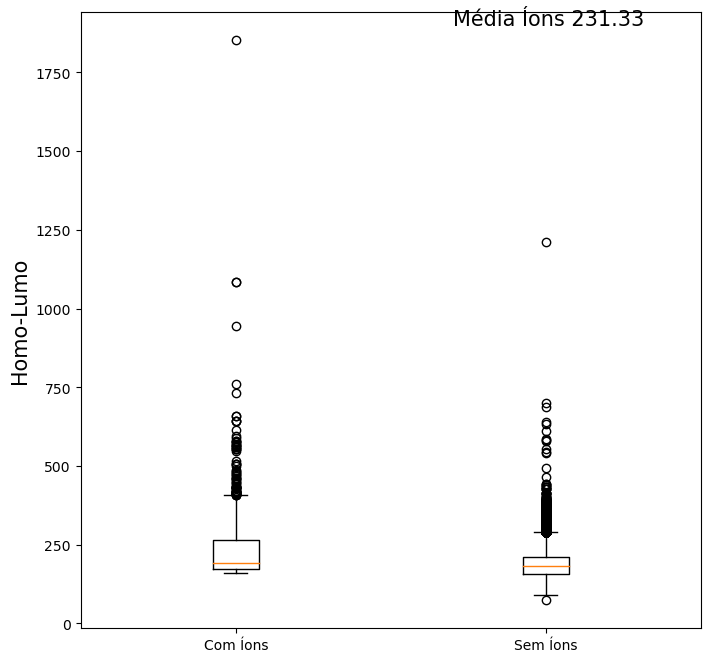

In [12]:
m = df["smiles"]

ions = []
n_ions = []
count = 0

for i in m:
    if "+" in i:
        ions.append(df.loc[count, "homo_lumo_nm"])
    else:
        n_ions.append(df.loc[count, "homo_lumo_nm"])
    count += 1

dados = [ions, n_ions]
media_ions = np.mean(ions)
media_n_ions = np.mean(n_ions)

leg = ["Com Íons", "Sem Íons"]
plt.figure(figsize=(8,8))
plt.boxplot(dados, labels=leg)
plt.ylabel("Homo-Lumo", fontsize=15)
plt.text(1.7,1900,s=f"Média Íons {media_ions:.2f}", fontsize=15)

plt.show()



Notamos uma diferença entre a escala do terceiro quadrante, evidenciando a grande proporção de dados com íons acima da mediana. Desse modo, pode se considerar um dado importante para a análise.

In [13]:
m = df["smiles"]
lista_ions = []
count = 0

for i in m:
    if "+" in i:
        lista_ions.append(1) 
    else:
        lista_ions.append(0)

df["Ions"] = lista_ions


In [18]:
df.head()

,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye,QNTD tN,lig. pi,QNTD O,QNTD C,QNTD N,QNTD F,QNTD_Atoms_aromatic,Ions
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848,1,4,0,8,1,0,0,0
1,OC12C3CC1=CCC23,16,262.009035,1.2579,0,1,1,7,0,0,0,0
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626,0,0,2,7,0,0,5,0
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264,0,0,0,6,3,0,5,0
4,CC1C2OC3CC1CC23,21,143.056110,1.7271,0,0,1,8,0,0,0,0


A próxima análise que aparenta interessar para o modelo, é a presença de átomos diferentes de carbono nos anéis aromáticos.

In [14]:
m = df["smiles"]
atom_symbol_list = []

for j in m:

    mol = Chem.MolFromSmiles(j)
    number_atoms = mol.GetNumAtoms()
    atom_symbol_aromatic = []

    for i in range(0,number_atoms):
        if mol.GetAtomWithIdx(i).GetIsAromatic():
            a = mol.GetAtomWithIdx(i).GetSymbol()
            atom_symbol_aromatic.append(a)

        else:
            atom_symbol_aromatic.append(0)

    atom_symbol_list.append(atom_symbol_aromatic)


In [15]:
# Observamos que não há átomos de fluor nos anéis aromáticos

qntd_O, qntd_N = [],[]

for molecula in atom_symbol_list:
    count_O, count_N = 0,0
    for atom in molecula:
        if atom == "O":
            count_O += 1
        elif atom == "N":
            count_N += 1
            
    qntd_O.append(count_O)
    qntd_N.append(count_N)


df["QNTD_O_Aromatic"] = qntd_O
df["QNTD_N_Aromatic"] = qntd_N

df.head()

,smiles,n_atoms,homo_lumo_nm,dipole_moment_debye,QNTD tN,lig. pi,QNTD O,QNTD C,QNTD N,QNTD F,QNTD_Atoms_aromatic,Ions,QNTD_O_Aromatic,QNTD_N_Aromatic
0,CC#CC1C(C)C1C#N,18,172.850422,3.7848,1,4,0,8,1,0,0,0,0,0
1,OC12C3CC1=CCC23,16,262.009035,1.2579,0,1,1,7,0,0,0,0,0,0
2,CC(C)(O)C1=CC=CO1,19,192.901656,1.1626,0,0,2,7,0,0,5,0,1,0
3,CC1C(C)C2=NC=NN12,18,167.574002,3.9264,0,0,0,6,3,0,5,0,0,3
4,CC1C2OC3CC1CC23,21,143.056110,1.7271,0,0,1,8,0,0,0,0,0,0


In [16]:
df.to_csv("dados_tratados.csv", index=False)